In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
data = pd.read_csv('./processed_data/aggregated_data/aggregated_bitcoin_data.csv')[-2000:]
data = data[['open_time', 'close', 'moving_average_20', 'moving_average_50', 'moving_average_100', 'rsi_20', 'rsi_50', 'rsi_100']]
data['open_time'] = pd.to_datetime(data['open_time'])
data.set_index('open_time', inplace=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_steps=60):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
        labels.append(data[i+time_steps][0])
    return np.array(sequences), np.array(labels)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, scaled_data.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=10, epochs=10)


Epoch 1/10


c:\Users\chang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0212
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.5112e-04
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.4506e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.5707e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.3911e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.8960e-04
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.3202e-04
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.1219e-04
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.5410e-04
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6212e-04


In [38]:
# Make predictions for the test set
predictions = model.predict(X_test)
scaler2 = MinMaxScaler(feature_range=(0, 1))
close_data = data[['close']]
scaled_data = scaler2.fit_transform(close_data)
predictions = scaler2.inverse_transform(predictions)

# Define a function to calculate RSI
def calculate_rsi(prices, period=14):
    gains = []
    losses = []
    for i in range(1, len(prices)):
        diff = prices[i] - prices[i - 1]
        if diff > 0:
            gains.append(diff)
            losses.append(0)
        else:
            gains.append(0)
            losses.append(abs(diff))

    avg_gain = sum(gains[:period]) / period
    avg_loss = sum(losses[:period]) / period

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calcular_next_secuence(close_prices):
    rsi_20 = calculate_rsi(close_prices, 20)
    rsi_50 = calculate_rsi(close_prices, 50)
    rsi_100 = calculate_rsi(close_prices, 100)
    mv_20 = sum(close_prices[-20:]) / 20
    mv_50 = sum(close_prices[-50:]) / 50
    mv_100 = sum(close_prices[-100:]) / 100
    secuence = [close_prices[-1][0],mv_20[0],mv_50[0],mv_100[0],rsi_20,rsi_50,rsi_100[0]]
    return secuence


# Predict future values
X_test = X_test[:200]
future_predictions = []
current_sequence = X_test[0]  # Start with the last test sequence
for _ in range(len(predictions)):
    next_prediction = model.predict(current_sequence.reshape(1, time_steps, X_train.shape[2]))
    future_predictions.append(next_prediction[0])
    close_prices = []
    for n in current_sequence[1:]:
        close_prices.append(n[0])
    close_prices.append(next_prediction[0])
    secuence =calcular_next_secuence(close_prices)
    current_sequence = np.append(current_sequence[1:], [secuence], axis=0)

future_predictions = scaler2.inverse_transform(future_predictions)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━

C:\Users\chang\AppData\Local\Temp\ipykernel_2828\825653600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
C:\Users\chang\AppData\Local\Temp\ipykernel_2828\825653600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Future_forecast'] = future_predictions


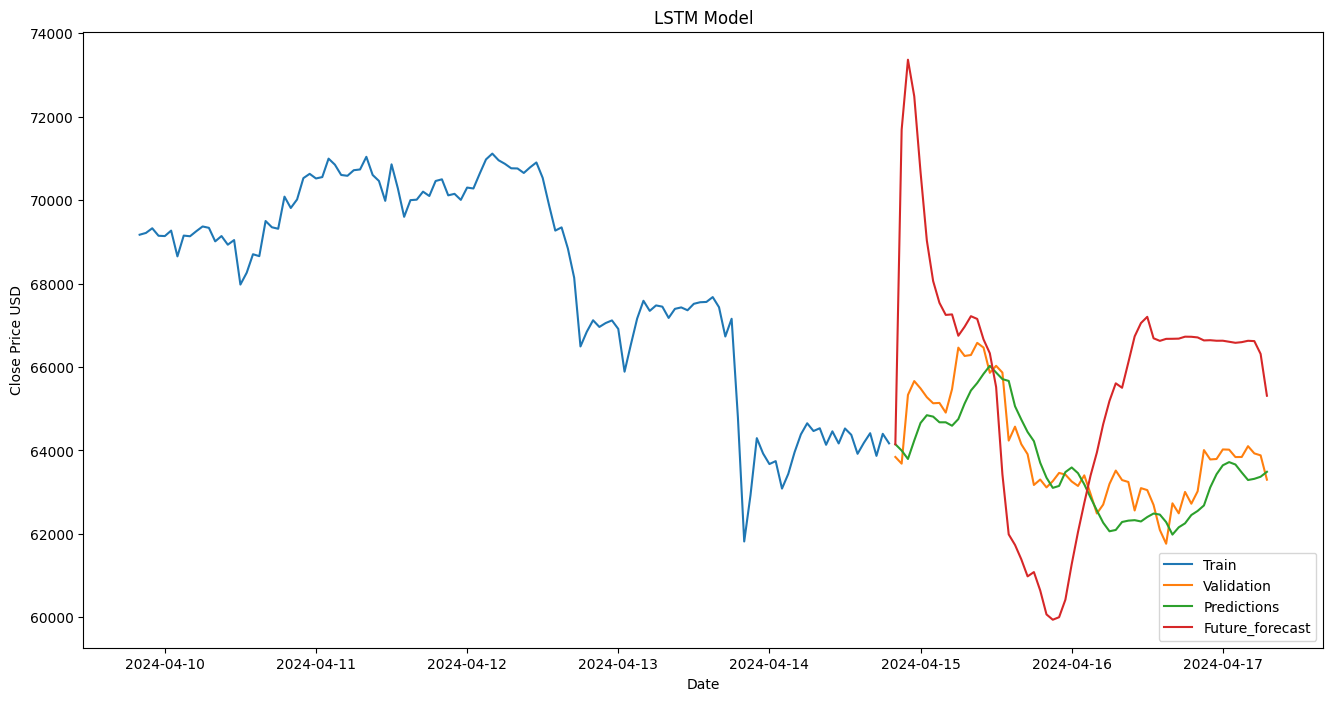

In [40]:
# Mostramos gráficamente
train = data[:train_size+time_steps]
valid = data[train_size+time_steps:]
valid['Predictions'] = predictions
valid['Future_forecast'] = future_predictions
train = train[-120:]
valid = valid[:60]
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['close'], label='Train')
plt.plot(valid[['close', 'Predictions','Future_forecast']], label=['Validation', 'Predictions','Future_forecast'])
plt.legend(loc='lower right')
plt.show()


In [41]:
model.save('modelos_con_indicador_tecnico.h5')